# Preprocess the Model for Ratio Reconstruction

### TO DO:
Have some simple tests that check data when loading. Leverage existing reading tools but add project specific checks later
*

In [1]:
from climpyrical.data import read_data, gen_dataset, interpolate_dataset
from climpyrical.gridding import regrid_ensemble, extend_north
from climpyrical.mask import stratify_coords
from pkg_resources import resource_filename

import pickle
import xarray as xr
import numpy as np
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib

import os

font = {'weight' : 'bold',
        'size'   : 28}

matplotlib.rc('font', **font)
plt.rcParams['figure.figsize'] = (10, 10)

%load_ext autoreload
%autoreload 2

TJan2.5
TJan1.0
TJul97.5
TwJul97.5
HDD
Tmax
Tmin
R15m10
R1d50
PAnn
RAnn
MI
SL50
RL50
WP10
WP50
DRWP5
RHann

## Interpolate the model

In [2]:
# Establish paths dictionary

station_dv = 'RL50 (kPa)'
station_dv = 'SL50 (kPa)'

# station_dv = 'mean RH (%)'
# station_dv = 'HDD (degC-day)'

# station_dv = 'TJan2.5 (degC)'
# station_dv = 'TJan1.0 (degC)'
# station_dv = 'TJul2.5 (degC)'
# station_dv = 'TwJul2.5 (degC)'
# station_dv = 'Tmin (degC)'
# station_dv = 'Tmax (degC)'

# station_dv = 'Q10_Gumbel-MM'
# station_dv = 'Q50_Gumbel-MM'
# station_dv = 'DRWP-RL5 (Pa)'
# station_dv = 'annual_pr (mm)'
# station_dv = 'annual_rain (mm)'
# station_dv = 'RL50 (mm)'

with open('station_dv.pickle', 'wb') as outfile:
    pickle.dump(station_dv, outfile)
    print("Pickled station dv: ", station_dv)

paths = {
    'RL50 (kPa)': 'nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc',
    'mean RH (%)': 'nrc_data/hurs_CanRCM4-LE_ens15_1951-2016_ensmean.nc',
    'HDD (degC-day)': 'nrc_data/hdd_CanRCM4-LE_ens35_1951-2016_ann_ensmean.nc',
    'SL50 (kPa)': 'nrc_data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc',
    'Q10_Gumbel-MM': 'nrc_data/wpress_CanRCM4-LE_ens35_1951-2016_max_rl10_kpa_ensmean.nc',
    'Q50_Gumbel-MM': 'nrc_data/wpress_CanRCM4-LE_ens35_1951-2016_max_rl50_kpa_ensmean.nc',
    'TJan2.5 (degC)': 'nrc_data/tas_CanRCM4-LE_ens35_1951-2016_1hr_jan2.5p_ensmean.nc',
    'TJan1.0 (degC)': 'nrc_data/tas_CanRCM4-LE_ens35_1951-2016_1hr_jan1.0p_ensmean.nc',
    'Tmax (degC)': 'nrc_data/tas_CanRCM4-LE_ens35_1951-2016_ann_max_ensmean.nc',
    'Tmin (degC)': 'nrc_data/tas_CanRCM4-LE_ens35_1951-2016_ann_min_ensmean.nc',
    'TwJul2.5 (degC)': 'nrc_data/twb_CanRCM4-LE_ens35_1951-2016_1hr_jul97.5p_ensmean.nc',
    'TJul2.5 (degC)': 'nrc_data/tas_CanRCM4-LE_ens35_1951-2016_1hr_jul97.5p_ensmean.nc',
    'DRWP-RL5 (Pa)': 'nrc_data/DRWP_CanRCM4-LE_ens15_1951-2016_RL5_ensmean.nc',
    'annual_pr (mm)': 'nrc_data/pr_CanRCM4-LE_ens35_1951-2016_ann_sum_ensmean.nc',
    'annual_rain (mm)': 'nrc_data/rain_CanRCM4-LE_ens35_1951-2016_ann_sum_ensmean.nc',
    'RL50 (mm)': 'nrc_data/rain_CanRCM4-LE_ens35_1951-2016_annmax_rl50_ensmean.nc'
    
}

filenames = {
    'RL50 (kPa)': 'RL50',
    'mean RH (%)': 'RHann',
    'HDD (degC-day)': 'HDD',
    'SL50 (kPa)': 'SL50',
    'Q10_Gumbel-MM': 'WP10',
    'Q50_Gumbel-MM': 'WP50',
    'TJan2.5 (degC)': 'TJan2.5',
    'TJan1.0 (degC)': 'TJan1.0',
    'Tmin (degC)': 'Tmin',
    'Tmax (degC)': 'Tmax',
    'TJul2.5 (degC)': 'TJul97.5',
    'TwJul2.5 (degC)': 'TwJul97.5',
    'DRWP-RL5 (Pa)': 'DRWP5',
    'annual_pr (mm)': 'PAnn',
    'annual_rain (mm)': 'RAnn',
    'RL50 (mm)': 'R1d50'
}

file_dv = filenames[station_dv]

PATH_MEAN_SNOW = resource_filename(
    'climpyrical', 
    'nrc_data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
)

PATH_MEAN = resource_filename(
    'climpyrical',
    paths[station_dv]
)

ds_mean = read_data(PATH_MEAN)
dv = list(ds_mean.data_vars)[0]

rlon, rlat = np.meshgrid(ds_mean.rlon, ds_mean.rlat)
mean = ds_mean[dv].values

if 'degC' in station_dv and not 'degC-day' in station_dv:
    mean = ds_mean[dv].values + 273.15
else:
    mean = ds_mean[dv].values
    
ds_mean.to_netcdf(resource_filename("climpyrical", "tests/data/example2.nc"))

Pickled station dv:  SL50 (kPa)


In [17]:
mask_ds = xr.open_dataset(
    resource_filename("climpyrical", "nrc_data/canada_mask_rp.nc")
)
mask_ds

<xarray.Dataset>
Dimensions:  (rlat: 1510, rlon: 1550)
Coordinates:
  * rlon     (rlon) float64 -34.28 -34.23 -34.19 -34.14 ... 34.19 34.23 34.28
  * rlat     (rlat) float64 -29.0 -28.95 -28.91 -28.86 ... 37.77 37.82 37.86
Data variables:
    mask     (rlat, rlon) bool ...

Load the Surface to Land Fraction Mask `sftlf`

In [7]:
PATH_MASK = resource_filename('climpyrical', 'nrc_data/land_mask_CanRCM4_sftlf.nc')
PATH_GLACIER_MASK = resource_filename('climpyrical', 'nrc_data/glacier_mask.nc')

# load mask data
mask = read_data(PATH_MASK)

# regrid dataset to target resolution
mask = regrid_ensemble(mask, 'sftlf', 10, copy=True)

# convert to boolean mask
mask = mask['sftlf'] >= 1.0

In [8]:
mask_og = read_data(PATH_MASK)['sftlf'].values != 0.0
glaciermask = read_data(PATH_GLACIER_MASK)['mask'].values != 0.0

fill_glaciers = True
if fill_glaciers:
    mean[glaciermask] = np.nan


nanmask = ~np.isnan(mean)

ds_mean = ds_mean.assign({
                    dv: (["rlat", "rlon"], mean)
})

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_values = mean[nanmask]
target_points = np.stack([rlon[glaciermask], rlat[glaciermask]]).T

mean[glaciermask] = interpolate_dataset(points, target_values, target_points, 'linear')
ds_mean_glacier_filled = gen_dataset(dv, mean, ds_mean.rlat, ds_mean.rlon, ds_mean.lat, ds_mean.lon)

In [9]:
# send to DVE
regrid_ensemble(ds_mean_glacier_filled, dv, 10, copy=True, required_keys=['rlat', 'rlon']).to_netcdf(f'~/dash-dv-explorer/assets/data/ensemble/{file_dv}_10_ensemble_mean.nc')

In [10]:
path_shapefile = resource_filename('climpyrical', 'nrc_data/canada_final.shp')
canada = gpd.read_file(path_shapefile).geometry
X, Y = stratify_coords(canada)

In [12]:
# from climpyrical.mask import rotate_shapefile

# font = {'weight' : 'bold',
#         'size'   : 8}

# matplotlib.rc('font', **font)
# plt.rcParams['figure.figsize'] = (13, 13)

# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# rotated_world = rotate_shapefile(world)
# rotated_world = rotated_world[(rotated_world.name != 'Russia') & (rotated_world.continent != "Antarctica")]
# rotated_world.plot(color = 'seagreen')
# plt.ylim(-80, 60)
# plt.xlabel('rotated longitude [deg]', fontsize=17)
# plt.ylabel('rotated latitude [deg]', fontsize=17)
# plt.plot()
# plt.title('Rotated Pole Projection Used in CanRCM4 Model', fontsize=20)
# plt.tight_layout()

# plt.savefig('/home/nannau/Desktop/rotated_pole_world.png')

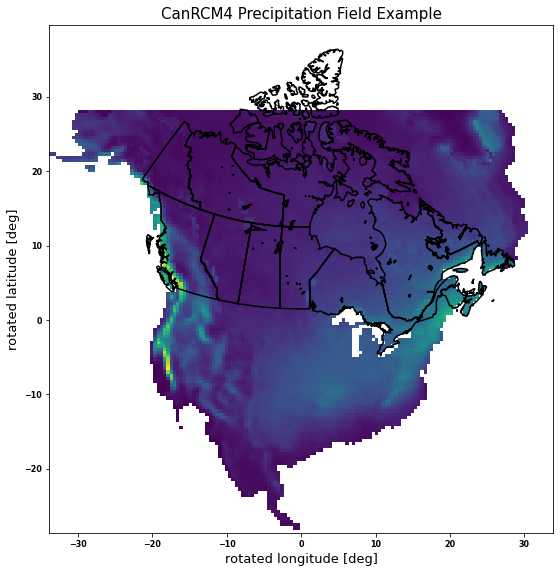

In [13]:
plt.figure(figsize=(8, 8))
plt.imshow(ds_mean_glacier_filled[dv], origin='lower', extent=[ds_mean_glacier_filled.rlon.min(), ds_mean_glacier_filled.rlon.max(), ds_mean_glacier_filled.rlat.min(), ds_mean_glacier_filled.rlat.max()])
plt.plot(X, Y, color='black')
plt.xlabel('rotated longitude [deg]', fontsize=13)
plt.ylabel('rotated latitude [deg]', fontsize=13)
plt.plot()
plt.title('CanRCM4 Precipitation Field Example', fontsize=15)
plt.tight_layout()
plt.savefig('/home/nannau/Desktop/CanRCM4_rotated_pole')

# Mask out ocean values

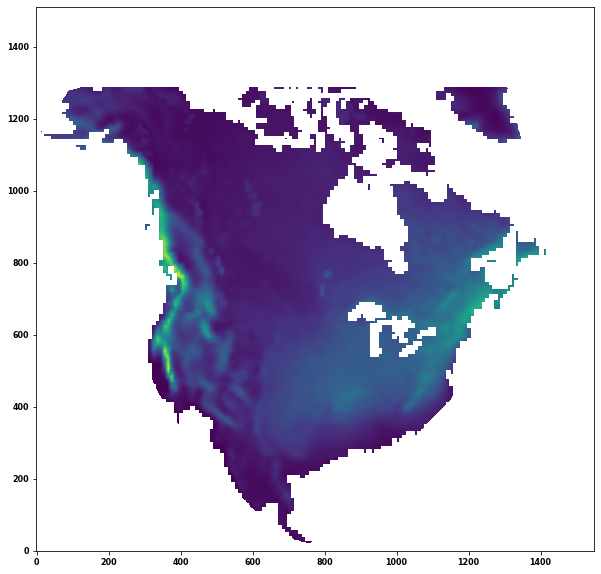

In [14]:
# make all water values NaN at original resolution
ds_mean_glacier_filled[dv].values[~mask_og] = np.nan
rlon, rlat = np.meshgrid(ds_mean_glacier_filled.rlon, ds_mean_glacier_filled.rlat)
nanmask = ~np.isnan(ds_mean_glacier_filled[dv].values)

# copy newly masked dv field to target resolution
ds10_cp = regrid_ensemble(ds_mean_glacier_filled, dv, 10, copy=True)

# Mask out ocean values
ds10_cp[dv].values[~mask] = np.nan
nrlon, nrlat = np.meshgrid(ds10_cp.rlon, ds10_cp.rlat)
nanmask10 = ~np.isnan(ds10_cp[dv].values)

# bilinearly interpolate over non NaN grids
points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([nrlon[nanmask10], nrlat[nanmask10]]).T
target_values = ds_mean_glacier_filled[dv].values[nanmask]
ds10_cp[dv].values[nanmask10] = interpolate_dataset(points, target_values, target_points, 'linear')

# extend the northern region 
ds10_cp_ext = extend_north(ds10_cp, dv, 210, fill_val=np.nan)

# create nanmask for interpolation
nanmask10 = ~np.isnan(ds10_cp_ext[dv].values)
ds_mean10_nx = ds10_cp_ext.copy()

plt.figure(figsize=(10, 10))
plt.imshow(ds10_cp_ext[dv].values, origin='lower')

False

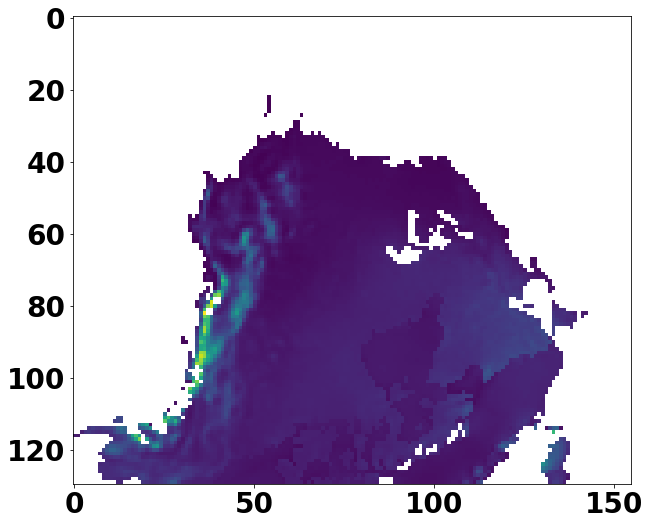

In [26]:
plt.imshow(read_data(
    resource_filename("climpyrical", "tests/data/example2.nc")
)['snw'])

bool(np.all(read_data(resource_filename("climpyrical", "tests/data/example2.nc")).to_array().isnull()).values)

In [30]:
dstest = read_data(
    resource_filename("climpyrical", "tests/data/example2.nc")
)

# dstest = regrid_ensemble(dstest, 'snw', 10, copy=True)#.to_netcdf(resource_filename("climpyrical", "tests/data/snw_target_res.nc"))

# plt.imshow(dstest['snw'])
from climpyrical.data import check_valid_data
check_valid_data(dstest)

In [42]:
error = ValueError
error = UserWarning
# isinstance(x, ValueError)
isinstance(error, type(ValueError))

True

Load final refined mask. If not accessible, or desire difference shapefile, follow `mask.ipynb`

/home/nannau/tri/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


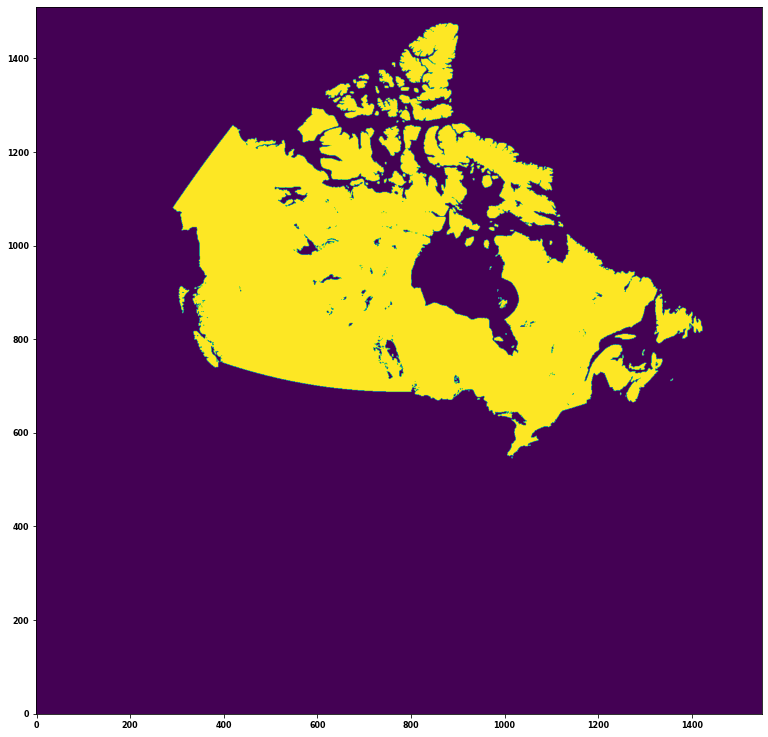

In [12]:
mask_path = resource_filename('climpyrical', '/nrc_data/processed/canada_mask_rp.nc')
# mask_path_out = resource_filename('climpyrical', '/nrc_data/processed/canada_mask_rp_new.nc')

with read_data(mask_path) as ds:
    rmask = extend_north(ds, 'mask', 210, fill_val=np.nan)
    rmask = ds['mask'].values

plt.imshow(rmask, origin='lower')

Find inconsistent areas between the refined mask and the model by comparing model values with refined mask values

No handles with labels found to put in legend.


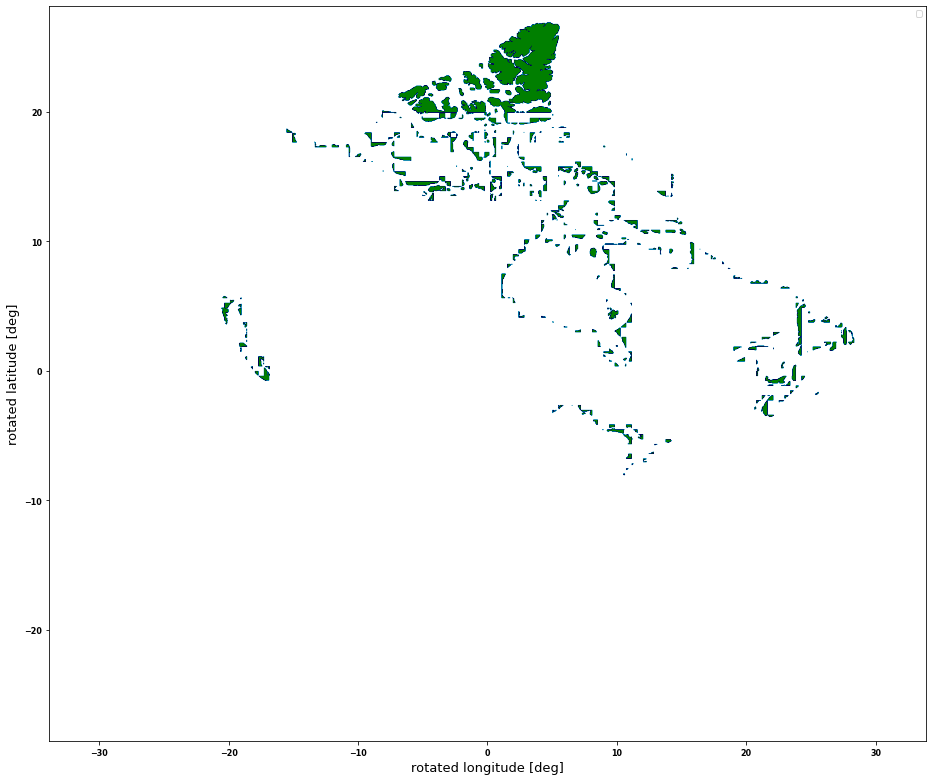

In [13]:
nanmask10 = ~np.isnan(ds_mean10_nx[dv])
rmask_or = ~np.logical_or(~rmask, nanmask10)

matplotlib.rc('font', **font)
plt.rcParams['figure.figsize'] = (13, 13)
plt.figure(figsize=(13, 13))
plt.imshow(rmask_or, origin='lower', cmap='ocean_r', extent=[ds_mean_glacier_filled.rlon.min(), ds_mean_glacier_filled.rlon.max(), ds_mean_glacier_filled.rlat.min(), ds_mean_glacier_filled.rlat.max()])
plt.xlabel('rotated longitude [deg]', fontsize=13)
plt.ylabel('rotated latitude [deg]', fontsize=13)
plt.plot()
plt.legend()
# plt.title('Rotated Pole Projection Used in CanRCM4 Model', fontsize=20)
plt.tight_layout()
plt.savefig('/home/nannau/Desktop/diff_mask')

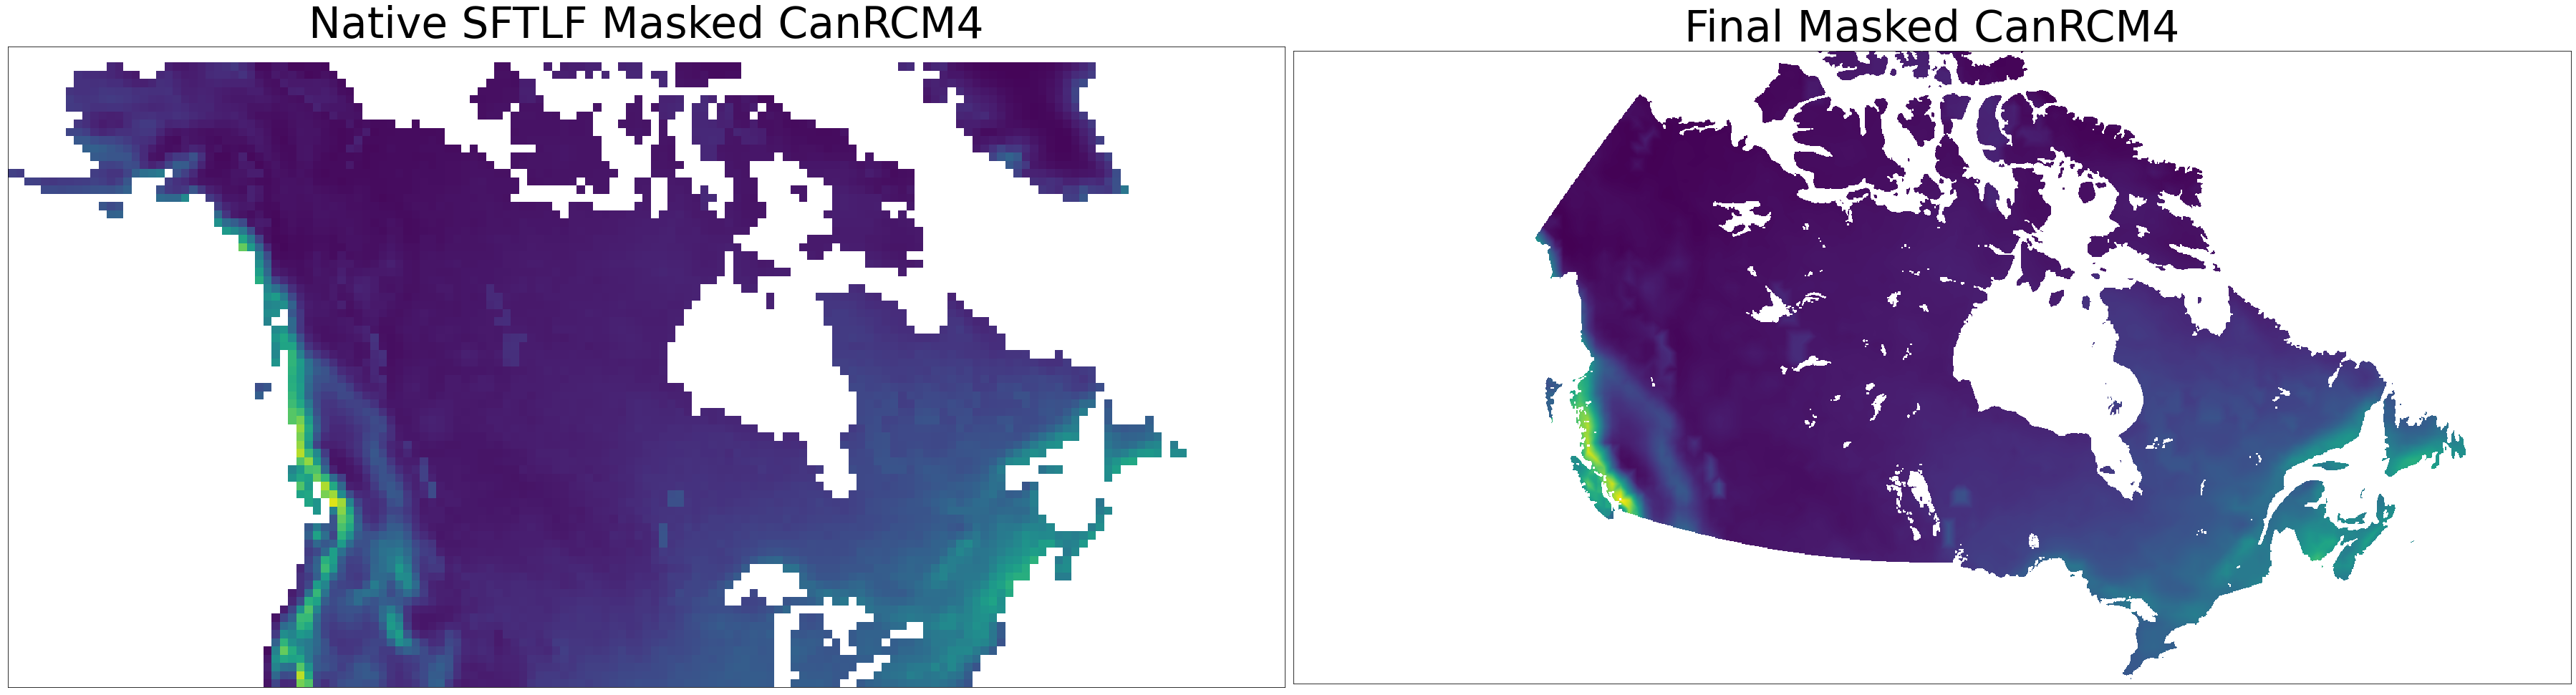

In [14]:
# Fill inconsistent points using closest neighbour.
# Not that the northern section will be filled later on
nrlon, nrlat = np.meshgrid(ds10_cp_ext.rlon.values, ds10_cp_ext.rlat.values)

temp_field = ds_mean10_nx[dv].values

points = np.stack([nrlon[nanmask10], nrlat[nanmask10]]).T
target_points = np.stack([nrlon[rmask_or], nrlat[rmask_or]]).T
target_values = ds_mean10_nx[dv].values[nanmask10]
# f = NearestNDInterpolator(points, ds_mean10_nx[dv].values[nanmask10])
# temp_field[rmask_or] = f(np.stack([nrlon[rmask_or], nrlat[rmask_or]]).T)
temp_field[~rmask] = np.nan
temp_field[rmask_or] = interpolate_dataset(points, target_values, target_points, 'nearest')
mean10_ext_f = gen_dataset(dv, temp_field, ds_mean10_nx.rlat, ds_mean10_nx.rlon, ds_mean10_nx.lat, ds_mean10_nx.lon)
# mean10_ext_f = xr.Dataset(
#     {dv: (["rlat", "rlon"], temp_field)},
#     coords={"rlon": ("rlon", ds_mean10_nx.rlon), "rlat": ("rlat", ds_mean10_nx.rlat)},
# )
mean10_ext_f
fig, ax = plt.subplots(1, 2, figsize=(50, 30))
extent = [ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()]
extent1 = [ds_mean.rlon.min(), ds_mean.rlon.max(), ds_mean.rlat.min(), ds_mean.rlat.max()]

ax[1].imshow(mean10_ext_f[dv], origin='lower', extent=extent)
ax[0].set_title("Native SFTLF Masked CanRCM4", fontsize=60)
ax[1].set_title("Final Masked CanRCM4", fontsize=60)
ax[0].imshow(ds_mean[dv], origin='lower', extent=extent1)
ax[1].set_ylim(-5, 29)
ax[0].set_ylim(-5, 29)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.tight_layout()
plt.savefig('/home/nannau/Desktop/before_after')
X, Y = stratify_coords(canada)
extent = [ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()]

path_shapefile = resource_filename('climpyrical', 'nrc_data/canada_final.shp')
canada = gpd.read_file(path_shapefile).geometry
# plt.plot(X, Y)

In [15]:
# Check all inconsistencies are filled
assert ~np.any(~np.logical_or(~rmask, ~np.isnan(mean10_ext_f[dv]))).values
ds_mean10_nx.lat

<xarray.DataArray 'lat' (rlat: 1510, rlon: 1550)>
array([[11.85176892, 11.86818269, 11.88457881, ..., 11.88457881,
        11.86818269, 11.85176892],
       [11.89188802, 11.90831123, 11.9247168 , ..., 11.9247168 ,
        11.90831123, 11.89188802],
       [11.93200581, 11.94843847, 11.96485349, ..., 11.96485349,
        11.94843847, 11.93200581],
       ...,
       [63.55804073, 63.59066087, 63.62328137, ..., 63.62328137,
        63.59066087, 63.55804073],
       [63.57401594, 63.60663482, 63.6392541 , ..., 63.6392541 ,
        63.60663482, 63.57401594],
       [63.58993114, 63.62254868, 63.65516664, ..., 63.65516664,
        63.62254868, 63.58993114]])
Coordinates:
    lat      (rlat, rlon) float64 11.85 11.87 11.88 11.9 ... 63.66 63.62 63.59
    lon      (rlat, rlon) float64 232.8 232.8 232.9 232.9 ... 354.5 354.5 354.5
  * rlon     (rlon) float64 -34.28 -34.23 -34.19 -34.14 ... 34.19 34.23 34.28
  * rlat     (rlat) float64 -29.0 -28.95 -28.91 -28.86 ... 37.77 37.82 37.86

In [16]:
ds_mean.lon.values

array([[232.93087769, 233.29016113, 233.6505127 , ..., 292.3494873 ,
        292.70983887, 293.06912231],
       [232.74105835, 233.10229492, 233.46459961, ..., 292.53540039,
        292.89770508, 293.25894165],
       [232.55062866, 232.91381836, 233.27807617, ..., 292.72192383,
        293.08618164, 293.44934082],
       ...,
       [190.95722961, 191.42147827, 191.89193726, ..., 334.10803223,
        334.57852173, 335.04275513],
       [190.28536987, 190.74536133, 191.21156311, ..., 334.78842163,
        335.25460815, 335.71459961],
       [189.60310364, 190.05856323, 190.52023315, ..., 335.47976685,
        335.94143677, 336.3968811 ]])

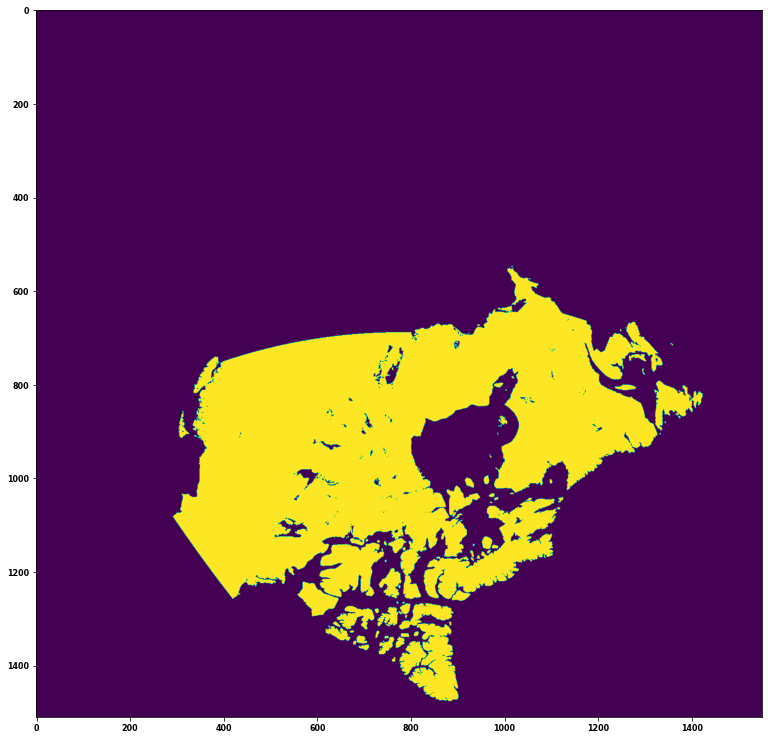

In [19]:
mask_ds = xr.open_dataset(
    resource_filename("climpyrical", "nrc_data/canada_mask_rp.nc")
)
plt.imshow(mask_ds['mask'].values)

In [17]:
# # find NaN values in ensemble mean
# mean_glacier_filled = mean10_ext_f[dv].values
# nanmask = ~np.isnan(mean10_ext_f[dv].values)
# print(nanmask.shape)
# # create interpolator for non NaN values
# # new coordinates to interpolate to (ds10_cp_ext is at target resolution)
# nrlon, nrlat = np.meshgrid(mean10_ext_f.rlon.values, mean10_ext_f.rlat.values)

# points = np.stack([nrlon[nanmask], nrlat[nanmask]]).T
# target_points = np.stack([nrlon[nanmask], nrlat[nanmask]]).T

# mean10 = mean10_ext_f[dv].values
# mean10[nanmask] = interpolate_dataset(points, mean_glacier_filled[nanmask], target_points, 'linear')

# ds_mean10_nx = gen_dataset(dv, mean10, mean10_ext_f.rlon.values, mean10_ext_f.rlat.values)

# plt.figure(figsize=(30, 30))
# plt.imshow(ds_mean10_nx[dv], origin='lower')

In [21]:
pre_processed_path = resource_filename(
    "climpyrical", 
    f"/nrc_data/processed/{file_dv}_pre_processed.nc"
)

if os.path.exists(pre_processed_path):
    os.remove(pre_processed_path)
    mean10_ext_f.to_netcdf(pre_processed_path, 'w')
else:
    mean10_ext_f.to_netcdf(pre_processed_path, 'w')

True

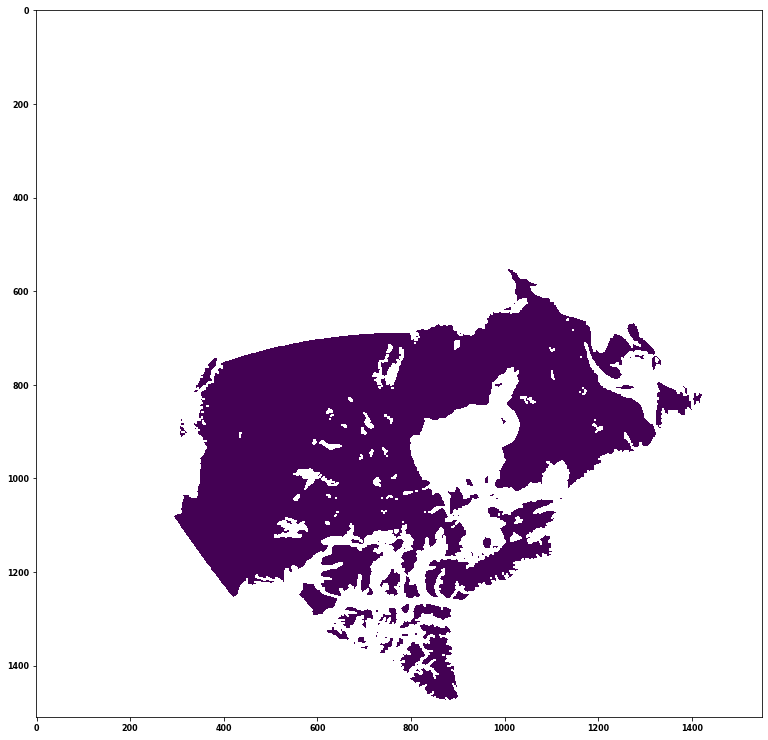

In [35]:
ds_script = read_data('/home/nannau/11192020/climpyrical/climpyrical/cmd/output.nc')
plt.imshow(mean10_ext_f[dv].values-ds_script[dv].values)
np.allclose((mean10_ext_f[dv].values - ds_script[dv].values)[rmask], 0.0)

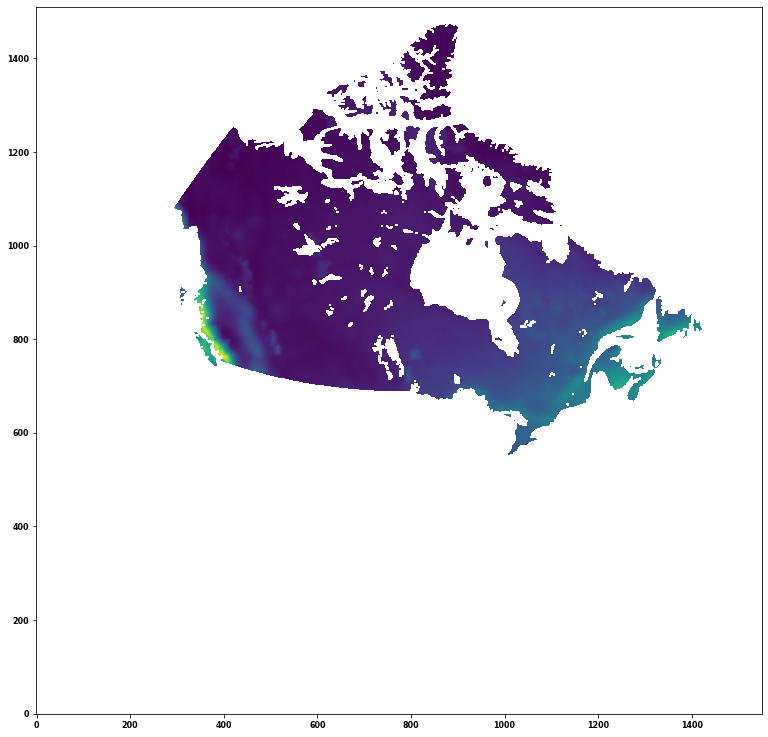

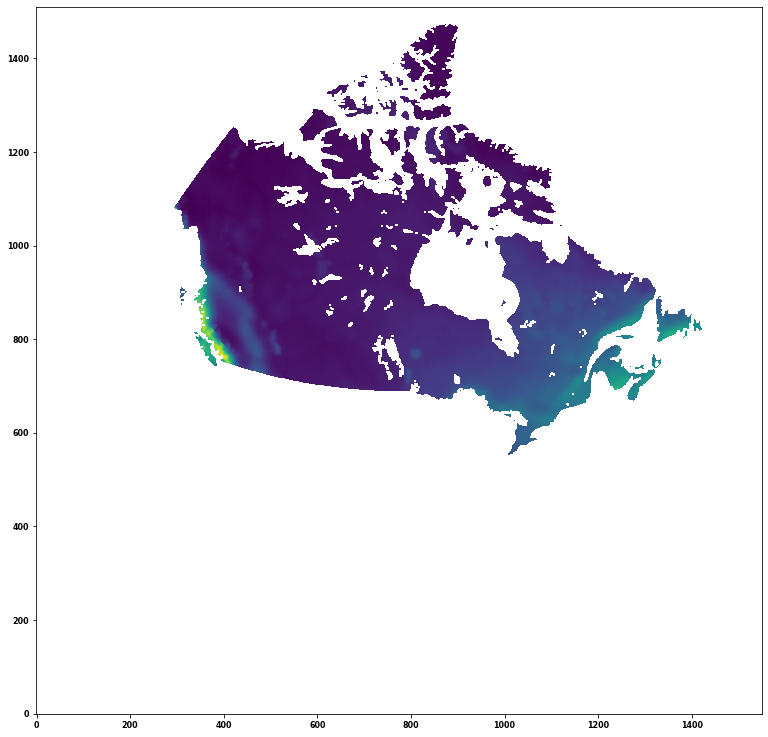

<xarray.Dataset>
Dimensions:    (rlat: 1510, rlon: 1550)
Coordinates:
    lat        (rlat, rlon) float64 11.85 11.87 11.88 11.9 ... 63.66 63.62 63.59
    lon        (rlat, rlon) float64 232.8 232.8 232.9 ... 354.5 354.5 354.5
  * rlon       (rlon) float64 -34.28 -34.23 -34.19 -34.14 ... 34.19 34.23 34.28
  * rlat       (rlat) float64 -29.0 -28.95 -28.91 -28.86 ... 37.77 37.82 37.86
Data variables:
    Rain-RL50  (rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan nan

In [20]:
plt.imshow(mean10_ext_f[dv].values, origin='lower')
plt.show()
plt.imshow(read_data('/home/nannau/11192020/climpyrical/climpyrical/cmd/output.nc')['Rain-RL50'], origin='lower')
plt.show()

read_data('/home/nannau/11192020/climpyrical/climpyrical/cmd/output.nc')